In [3]:
import os
os.chdir('/Users/Пользователь/Desktop/Skill Factory/data')
os.getcwd()

'C:\\Users\\Пользователь\\Desktop\\Skill Factory\\data'

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_rows', 500)

 ### train.csv

- **row_id: (int64)** ID строки
- **timestamp: (int64)** время в милисекундах между началом взаимодействия и завершением задания юзером
- **user_id: (int32)** ID пользователя
- **content_id: (int16)** ID номер вопроса или лекции
- **content_type_id: (int8)** 0 - вопрос(ы), 1 - лекция
- **task_container_id: (int16)** ID блока вопросов или лекции (может включать в себя несколько content_id). монотонно увеличивается для каждого пользователя
- **user_answer: (int8)** ответ пользователя на вопрос. -1 - пустое значение для лекций
- **answered_correctly: (int8)** 1 -ответил верно, 0 -неверно, -1 -пустое значение для лекций
- **prior_question_elapsed_time: (float32)** среднее время в милисекундах, затраченное пользователем на каждый ответ в предыдущем блоке вопросов (лекции в промежутке игнорируются). Если блок является первым тестируемым, значение значение 0.
- **prior_question_had_explanation: (bool)** видел ли пользователь правильный ответ и объяснение на предыдущий блок вопросов (лекции в промежутке игнорируются). Для первого - значение 0. Обычно первые вопросы, которые видит юзер - вступительный тест, на который нет фидбека.

### lectures.csv
- **lecture_id** ключ, для тех случаев когда train/test content_id соответствует значению лекция, т.е. 1.
- **part** указывает к какой категории относится лекция.
- **tag** каждой лекции присвоен тег, по данным кодам данные могут быть класторизованы
- **type_of** короткое описание основной цели лекции

### questions.csv

 - **question_id** ключ, для тех случае, когда значение колонки train/test content_id соответствует типу вопрос, т.е. равно 0
 - **bundle_id** признак для объединения вопросов в единые блоки, в task_container_id.
 - **correct_answer** - правильный ответ на вопрос, может быть сопоставлен в колонкой train user_answer column, для проверки правильности ответа пользователя
 - **part** соответствующая часть TOEIC теста. В тесте 7 частей с 1-4 - аудирование, 5-7 - чтение с выполнением заданий. Всего в тесте 200 вопросов (1 часть - 6; 2 часть - 25; 3 часть - 39; 4 часть - 30; 5 часть - 30; 6 часть - 16; 7 часть - 54.
 - **tags** значения тегов не приведены, но по коду тега, вопросы могут быть кластеризованы.

In [88]:
train = pd.read_csv("train2.csv")
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
5,5,157063,115,156,0,5,2,1,5000.0,False
6,6,176092,115,51,0,6,0,1,17000.0,False
7,7,194190,115,50,0,7,3,1,17000.0,False
8,8,212463,115,7896,0,8,2,1,16000.0,False
9,9,230983,115,7863,0,9,0,1,16000.0,False


In [89]:
train.shape

(65535, 10)

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          65535 non-null  int64  
 1   timestamp                       65535 non-null  int64  
 2   user_id                         65535 non-null  int64  
 3   content_id                      65535 non-null  int64  
 4   content_type_id                 65535 non-null  int64  
 5   task_container_id               65535 non-null  int64  
 6   user_answer                     65535 non-null  int64  
 7   answered_correctly              65535 non-null  int64  
 8   prior_question_elapsed_time     64108 non-null  float64
 9   prior_question_had_explanation  65295 non-null  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 5.0+ MB


оптимизируем данные, согласно приведенному условию

In [91]:
train['user_id'] = train['user_id'].astype('int32')
train['content_id'] = train['content_id'].astype('int16')
train['content_type_id'] = train['content_type_id'].astype('int8')
train['task_container_id'] = train['task_container_id'].astype('int16')
train['user_answer'] = train['user_answer'].astype('int8')
train['answered_correctly'] = train['answered_correctly'].astype('int8')
train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].astype('float32')
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          65535 non-null  int64  
 1   timestamp                       65535 non-null  int64  
 2   user_id                         65535 non-null  int32  
 3   content_id                      65535 non-null  int16  
 4   content_type_id                 65535 non-null  int8   
 5   task_container_id               65535 non-null  int16  
 6   user_answer                     65535 non-null  int8   
 7   answered_correctly              65535 non-null  int8   
 8   prior_question_elapsed_time     64108 non-null  float32
 9   prior_question_had_explanation  65535 non-null  bool   
dtypes: bool(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 2.0 MB


In [93]:
lectures = pd.read_csv("lectures.csv")
lectures.head(5)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [94]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [95]:
questions = pd.read_csv("questions.csv")
questions.head(5)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [13]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [96]:
qwe=questions[['question_id','part']]
qwe.head(5)

,question_id,part
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


оптимизируем данные lectures и questions согласно заданным условиям

In [97]:
lectures['lecture_id']= lectures['lecture_id'].astype('int16')
lectures['tag']= lectures['tag'].astype('int8')
lectures['part']= lectures['part'].astype('int8')
questions['question_id'] = questions['question_id'].astype('int16')
questions['bundle_id'] = questions['bundle_id'].astype('int8')
questions['correct_answer'] = questions['correct_answer'].astype('int8')
questions['part'] = questions['part'].astype('int8')

In [98]:
lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,11.801435,4.267943
std,9426.164660,82.644199,1.872424
min,89.000000,-128.000000,1.000000
25%,9026.250000,-82.000000,2.000000
50%,17161.500000,36.000000,5.000000
75%,24906.250000,78.000000,6.000000
max,32736.000000,127.000000,7.000000


Объеденим данные двуx таблиц train и questions, чтобы получить информацию о соответствии вопросов пользователя соответствующим частям экзамена

In [102]:
train = pd.read_csv('train2.csv')

train = train.merge(questions, left_on = 'content_id', right_on = 'question_id', how = 'left')

train = train[train.content_type_id == False]
train = train[train.answered_correctly!= -1 ]
train.drop(['content_type_id'], axis=1, inplace=True)
train.dropna(inplace=True)
train.head(5)

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
1,1,56943,115,5716,2,2,1,37000.0,False,5716.0,84.0,2.0,5.0,168
2,2,118363,115,128,0,0,1,55000.0,False,128.0,-128.0,0.0,1.0,131 149 92
3,3,131167,115,7860,3,0,1,19000.0,False,7860.0,-76.0,0.0,1.0,131 104 81
4,4,137965,115,7922,4,1,1,11000.0,False,7922.0,-14.0,1.0,1.0,131 149 92
5,5,157063,115,156,5,2,1,5000.0,False,156.0,-100.0,2.0,1.0,131 101 162 38


In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64108 entries, 1 to 65534
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          64108 non-null  int64  
 1   timestamp                       64108 non-null  int64  
 2   user_id                         64108 non-null  int64  
 3   content_id                      64108 non-null  int64  
 4   task_container_id               64108 non-null  int64  
 5   user_answer                     64108 non-null  int64  
 6   answered_correctly              64108 non-null  int64  
 7   prior_question_elapsed_time     64108 non-null  float64
 8   prior_question_had_explanation  64108 non-null  object 
 9   question_id                     64108 non-null  float64
 10  bundle_id                       64108 non-null  float64
 11  correct_answer                  64108 non-null  float64
 12  part                            

In [104]:
train['user_id'] = train['user_id'].astype('int32')
train['content_id'] = train['content_id'].astype('int16')
train['task_container_id'] = train['task_container_id'].astype('int16')
train['user_answer'] = train['user_answer'].astype('int8')
train['answered_correctly'] = train['answered_correctly'].astype('int8')
train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].astype('float32')
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')
train['question_id'] = train['question_id'].astype('int16')
train['part'] = train['part'].astype('int8')

In [105]:
train.shape

(64108, 14)

In [106]:
train.describe()

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,question_id,bundle_id,correct_answer,part
count,64108.000000,6.410800e+04,6.410800e+04,64108.000000,64108.000000,64108.000000,64108.000000,64108.000000,64108.000000,64108.000000,64108.000000,64108.000000
mean,32815.588008,6.901159e+09,7.258110e+05,4997.920447,963.553847,1.431459,0.694749,24734.687500,4997.920447,-0.249189,1.443221,4.045158
std,18934.649045,1.084701e+10,5.128382e+05,3347.975370,1202.344009,1.156899,0.460517,17157.742188,3347.975370,73.099172,1.154851,1.691514
min,1.000000,0.000000e+00,1.150000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-128.000000,0.000000,1.000000
25%,16410.750000,5.732909e+08,1.414550e+05,1915.750000,116.000000,0.000000,0.000000,16000.000000,1915.750000,-63.000000,0.000000,2.000000
50%,32798.500000,3.569071e+09,8.008240e+05,4975.000000,427.500000,1.000000,1.000000,21000.000000,4975.000000,2.000000,1.000000,5.000000
75%,49231.250000,9.228112e+09,1.282581e+06,7219.000000,1355.250000,3.000000,1.000000,28666.000000,7219.000000,61.000000,3.000000,5.000000
max,65534.000000,5.949531e+10,1.440282e+06,13522.000000,5261.000000,3.000000,1.000000,300000.000000,13522.000000,127.000000,3.000000,7.000000


In [107]:
definition = train['part'].value_counts(normalize=True)
definition.head(7)

5    0.376365
2    0.197963
6    0.121732
3    0.096337
4    0.084077
1    0.075498
7    0.048028
Name: part, dtype: float64

Создадим датафрейм на основании данных о названии частей экзамена и баллов за их прохождение. Данные с сайта www.iibc-global.org

In [108]:
df = pd.DataFrame([[1,'listening_Photographs',6],[2,'Listening_Question-Response',25],[3,'Listening_Conversations',39],[4,'Listening_Talks',30],[5,'Reading_Incomplete Sentences',30],[6, 'Reading_Text Completion',16],[7,'Reading_Passages',54]], index = [1,2,3,4,5,6,7], columns = ['number_part','type_of_part', 'score_for_the_part'])
df

,number_part,type_of_part,score_for_the_part
1,1,listening_Photographs,6
2,2,Listening_Question-Response,25
3,3,Listening_Conversations,39
4,4,Listening_Talks,30
5,5,Reading_Incomplete Sentences,30
6,6,Reading_Text Completion,16
7,7,Reading_Passages,54


#### Проанализируем структуру датасета train
Объединим датафрейм с данными о темах и частотой появления в датасете. Отсортируем по частоте появления в датасете

In [109]:
percent = pd.concat([df,definition], axis=1)
percent.rename({'part':'share_in_databox'},axis=1, inplace=True)
percent.sort_values('share_in_databox', ascending=False)

,number_part,type_of_part,score_for_the_part,share_in_databox
5,5,Reading_Incomplete Sentences,30,0.376365
2,2,Listening_Question-Response,25,0.197963
6,6,Reading_Text Completion,16,0.121732
3,3,Listening_Conversations,39,0.096337
4,4,Listening_Talks,30,0.084077
1,1,listening_Photographs,6,0.075498
7,7,Reading_Passages,54,0.048028


Реже всего в датасете встречаются вопросы, относящиеся к части 7, позволяющей набрать наибольшее количество баллов,
что говорит о том, что данная часть вопросов меняется редко, и пройдя все возможные вопросы по данной теме 
у пользователя повышается возможность ответа на следующий вопрос по данной теме корректно.

#### Проанализируем долю правильных ответов для каждой части теста

In [110]:
part_info = train.groupby(["part"]).agg({'answered_correctly':'sum', 'user_answer':'count'}).reset_index()
part_info['share_sucсess'] = part_info['answered_correctly']/part_info['user_answer']*100
part_info.index = [1,2,3,4,5,6,7]
part_info.insert(1, 'type_of_part', 5)
part_info['type_of_part']= df['type_of_part']
part_info.sort_values('share_sucсess', ascending=False)

,part,type_of_part,answered_correctly,user_answer,share_sucсess
1,1,listening_Photographs,3854.0,4840,79.628099
3,3,Listening_Conversations,4800.0,6176,77.720207
2,2,Listening_Question-Response,9279.0,12691,73.114806
7,7,Reading_Passages,2237.0,3079,72.653459
6,6,Reading_Text Completion,5632.0,7804,72.168119
4,4,Listening_Talks,3739.0,5390,69.369202
5,5,Reading_Incomplete Sentences,14998.0,24128,62.160146


In [111]:
import plotly.express as px
fig = px.bar(part_info, x='part', y='share_sucсess', labels={'part':'part','share_sucсess':'%_of_correct_answers'})
fig.show()

В датафрейме представлен рейтинг по степени убывания успешности ответа на вопрос. 
Таким образом, если следующий вопрос пользователя относится к 1 части теста, то вероятность ответа правильно выше, 
чем если вопрос относится к темам, стоящим ниже в рейтинге. 
Для вопросов 5 части, вероятность правильного ответа на последующего вопрос ниже всего 

#### Проанализируем наиболее часто втречающийся номер правильного ответа для каждого раздела

In [112]:
from scipy.stats import mode
agg_func_stats = {'correct_answer': [mode, pd.Series.mode]}
right_answer = train.groupby(['part']).agg(agg_func_stats).round(2)
right_answer['frequency_mode']= [int(right_answer.iloc[i][0][1]) for i in range(len(right_answer))]
right_answer['user_answer']=part_info['user_answer']
right_answer['interest_mode']= [(right_answer.iloc[i][2]/right_answer.iloc[i][3]*100) for i in range(len(right_answer))]
right_answer

correct_answer      frequency_mode user_answer interest_mode
                 mode mode                                         
part                                                               
1     ([0.0], [1277])  0.0           1277        4840     26.384298
2     ([0.0], [4440])  0.0           4440       12691     34.985423
3     ([0.0], [1621])  0.0           1621        6176     26.246762
4     ([1.0], [1394])  1.0           1394        5390     25.862709
5     ([0.0], [6323])  0.0           6323       24128     26.206068
6     ([0.0], [2228])  0.0           2228        7804     28.549462
7      ([2.0], [994])  2.0            994        3079     32.283209

In [113]:
import math
print(f'Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 1 раздела 0, вероятность правильного ответа составляет', round(right_answer.iloc[0][4],2),'%')
print(f'Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 2 раздела 0, вероятность правильного ответа составляет', round(right_answer.iloc[1][4],2),'%')
print(f'Если пользователь не знает ответ на вопро и выбирает в качестве ответа на вопрос из 3 раздела 1, вероятность правильного ответа составляет', round(right_answer.iloc[2][4],2),'%')
print(f'Если пользователь на знает ответ на вопрос и выбирает в качестве ответа на вопрос из 4 раздела 0, вероятность правильного ответа составляет', round(right_answer.iloc[3][4],2),'%')
print(f'Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 5 раздела 0, вероятность правильного ответа составляет', round(right_answer.iloc[4][4],2),'%')
print(f'Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 6 раздела 0, вероятность правильного ответа составляет', round(right_answer.iloc[5][4],2),'%')
print(f'Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 7 раздела 2, вероятность правильного ответа составляет', round(right_answer.iloc[6][4],2),'%')

Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 1 раздела 0, вероятность правильного ответа составляет 26.38 %
Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 2 раздела 0, вероятность правильного ответа составляет 34.99 %
Если пользователь не знает ответ на вопро и выбирает в качестве ответа на вопрос из 3 раздела 1, вероятность правильного ответа составляет 26.25 %
Если пользователь на знает ответ на вопрос и выбирает в качестве ответа на вопрос из 4 раздела 0, вероятность правильного ответа составляет 25.86 %
Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 5 раздела 0, вероятность правильного ответа составляет 26.21 %
Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 6 раздела 0, вероятность правильного ответа составляет 28.55 %
Если пользователь не знает ответ на вопрос и выбирает в качестве ответа на вопрос из 7 раздела 2, вероятность пра

#### Проанализируем зависимость между временем размышления над ответом на вопрос и его правильностью

In [114]:
mask = train['prior_question_elapsed_time'] > 0
a = train[mask]

In [115]:
a.groupby(["answered_correctly"]). mean()['prior_question_elapsed_time'].sort_values()

answered_correctly
0    24700.156250
1    24752.556641
Name: prior_question_elapsed_time, dtype: float32

время, затраченное на правильный ответ, практически не отличается от времени, затраченного на неправильный ответ, 
следовательно,  отсутствует прямая зависимость, между временем размышления над ответом, и вероятностью правильного ответа.

#### Рассмотрим зависимость между продолжительностью взаимодействия и долей правильных ответов

In [118]:
# 1 hour = 3600000ms
times = train.groupby(["user_id"]).agg({'answered_correctly':'sum', 'user_answer':'count', 'timestamp':'sum'}).reset_index()
times['effect'] = times['answered_correctly']/times['user_answer']*100
times['timestamp']= round(times['timestamp']/3600000,0)
times.head(5)

,user_id,answered_correctly,user_answer,timestamp,effect
0,115,31.0,45,1305.0,68.888889
1,124,6.0,29,3.0,20.689655
2,2746,11.0,18,2.0,61.111111
3,5382,83.0,124,12721.0,66.935484
4,8623,69.0,108,10440.0,63.888889


In [119]:
times.describe()

,user_id,answered_correctly,user_answer,timestamp,effect
count,2.410000e+02,241.000000,241.000000,2.410000e+02,241.000000
mean,7.064219e+05,184.809129,266.008299,5.099349e+05,53.878813
std,4.357603e+05,609.333787,794.542379,3.026930e+06,17.157072
min,1.150000e+02,0.000000,6.000000,0.000000e+00,0.000000
25%,3.551380e+05,11.000000,29.000000,5.000000e+00,43.396226
50%,7.128050e+05,24.000000,44.000000,2.014000e+03,57.142857
75%,1.102335e+06,87.000000,143.000000,5.872800e+04,66.000000
max,1.440282e+06,6195.000000,7475.000000,3.960359e+07,86.956522


очевидно, что 75% пользователей тратят на выполнение сессии 58728 часа, 
поэтому будем для анализа зависимости будем исследовать пользователей со временем менее указанной

<AxesSubplot:xlabel='timestamp', ylabel='effect'>

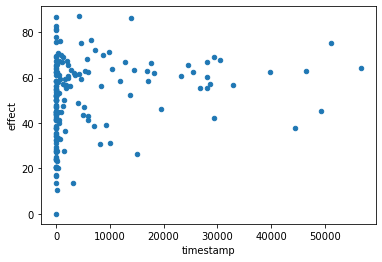

In [120]:
mask = times['timestamp'] < 5.872800e+04
b = times[mask]
b.plot.scatter(y='effect', x='timestamp')

как видим максимальная эффективность правильных ответов наблюдается в пределах до 30 000 часов, она достигает пика, до 87%, 
а потом существенно падает и на протяжении оставшегося времени сохраняется на уровне 55-65%. 
Для более точного анализа рассмотрим 50% пользователей, для которых время составляет до 2014 часов


<AxesSubplot:xlabel='timestamp', ylabel='effect'>

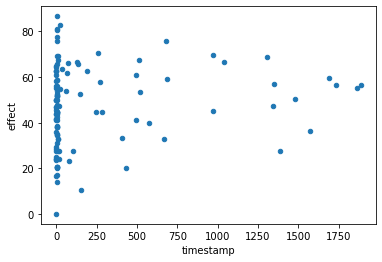

In [121]:
mask = times['timestamp'] < 2014
с = times[mask]
с.plot.scatter(y='effect', x='timestamp')

в целом нельзя указать на наличие прямой явной связи между продолжительностью сессии и увеличением доли правильности ответов. 
основная часть пользователей завершает сессию в промежутке от 0 до 5 часов с результатом от 45 до 65 %. 
Снижение количества пользователей продолжающих обучение более длительное время не показывает существенного улучшения результатов. в целом это может свидетельствовать и о том, что пользователей удовлетворяет результат теста 45-60% и они не намерены продолжать обучение в дальнейшем для повышения уровня знаний.
Посмотрим сколько времени большинство пользователей трятят на сессию

In [123]:
times['timestamp'].mode()

0    1.0
Name: timestamp, dtype: float64

проанализируем эффективность ответов в пределах от 0 до 5 часов

<AxesSubplot:xlabel='timestamp', ylabel='effect'>

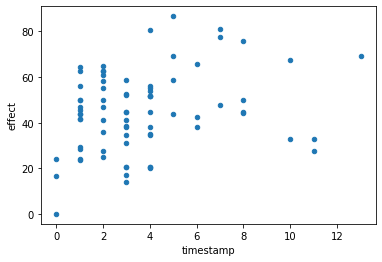

In [127]:
mask = times['timestamp'] < 15
d = times[mask]
d.plot.scatter(y='effect', x='timestamp')

максимальная эффективность, т.е. доля правильных ответов приходится на период между 1-2 часами,
далее происходит раздедение пользователей, для одних увеличение продолжительности приводит к улучшению результатов, 
для других к снижению доли правильных ответов. Для получения полной картины следует проанализировать, 
какие именно темы или лекции изучают студенты,входящие как в групу успешных, 
так и в группу снижающих успеваемость.
